Analysis to test the correlation and independence structure in generation.
* Validity of a row as a binary variable, is it correlated in the three rows? or independent 
* Conforming to one rule / one relation / one attribute as a binary variable is it correlated or independent? 


Use chi2 test and cramer's v test to quantify the deviation from independence?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary
from rule_new_utils import infer_rule_from_sample_batch, compute_rule_statistics, infer_rule_statistics_from_sample_batch, rule_table_brief, rule_table

In [4]:
import os
import numpy as np
import pandas as pd
import torch
from os.path import join
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm
from pprint import pprint

/tmp/ipykernel_1018326/3959933813.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


### Paths

In [5]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
# figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [6]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SSMfigdir = join(figroot, "SSM_raven")
SiTfigdir = join(figroot, "SiT_raven")

In [7]:
import pandas as pd
# Set the maximum column width to 100 characters
pd.set_option('display.max_colwidth', 100)

In [8]:
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SiT_raven

mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SiT_raven’: File exists


In [9]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_row_independence"
os.makedirs(figdir, exist_ok=True)

### Util functions for Rule learning dynamics 

Function to parse the experiment string

In [10]:
import re
def extract_and_convert(string):
    """Simple function to extract pattern like stream0_16 or stream16M and convert to float 0.16 or integer 16"""
    # Pattern to match the "0_16" part and convert to float 0.16
    match1 = re.search(r'stream(\d+)_(\d+)', string)
    if match1:
        num1 = str(match1.group(1))
        num2 = str(match1.group(2))
        result = float(f"{num1}.{num2}")
        return result
    
    # Pattern to match the "16M" part and convert to integer 16
    match2 = re.search(r'stream(\d+)M', string)
    if match2:
        result = int(match2.group(1))
        return result
    
    return None

Functions to load the samples and eval stats, plot the data

In [11]:
def sweep_collect_sample(expname, exproot, prefix=None, non_prefix=None):
    assert os.path.exists(join(exproot, expname, "samples")), expname  
    # print(sorted(os.listdir(join(exproot, expname, "samples"))))
    print(f"Extracted data from {join(exproot, expname, 'samples')}")
    print(f"example file:", os.listdir(join(exproot, expname, 'samples'))[0:10])
    # raise NotImplementedError("This function is not implemented yet")
    # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
    # TODO: check and fix the prefix prompt
    epoch_nums = sorted([int(f.split(prefix)[-1].split(".pt")[0]) for f in os.listdir(join(exproot, expname,'samples')) if not (non_prefix in f)])
    eval_col = {}
    for epoch_num in tqdm(epoch_nums):
        samples_eval = torch.load(join(exproot, expname, 'samples', f"{epoch_num:07d}.pt"))
        eval_col[epoch_num] = samples_eval
    return eval_col

In [12]:
def sweep_collect_eval_data(expname, exproot, prefix=None):
    assert os.path.exists(join(exproot, expname, "samples")), expname  
    # print(sorted(os.listdir(join(exproot, expname, "samples"))))
    print(f"Extracted data from {join(exproot, expname, 'samples')}")
    print(f"example file:", os.listdir(join(exproot, expname, 'samples'))[0])
    # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
    epoch_nums = sorted([int(f.split(prefix)[-1].split(".pt")[0]) for f in os.listdir(join(exproot, expname,'samples')) if prefix in f])
    eval_col = {}
    for epoch_num in tqdm(epoch_nums):
        samples_eval = torch.load(join(exproot, expname, 'samples', f"{prefix}{epoch_num}.pt"))
        eval_col[epoch_num] = samples_eval
    return eval_col

In [13]:
def extract_rule_list_from_eval_col(eval_col, is_abinit = False):
    epoch_list = sorted(list(eval_col.keys()))
    rule_list_all = []
    consistency_all = []
    for epoch in eval_col.keys():
        if is_abinit:
            rule_list_all.append(eval_col[epoch]['rule_col_list_abinit'])
            consistency_all.append((eval_col[epoch]['C3_list_abinit'], eval_col[epoch]['C2_list_abinit']))
        else:
            rule_list_all.append(eval_col[epoch]['rule_col_list'])
            consistency_all.append((eval_col[epoch]['C3_list'], eval_col[epoch]['C2_list']))
    rule_list_all = np.array(rule_list_all, dtype=object)
    consistency_all = np.array(consistency_all, dtype=object)
    print(rule_list_all.shape, consistency_all.shape)
    return epoch_list, rule_list_all, consistency_all


def extract_rule_list_from_eval_col_Diffusion(eval_col, ):
    print("diffusion model, just fetch ab init generation")
    epoch_list = sorted(list(eval_col.keys()))
    rule_list_all = []
    consistency_all = []
    for epoch in eval_col.keys():
        rule_list_all.append(eval_col[epoch]['rule_col'])
        consistency_all.append((eval_col[epoch]['c3_list'], eval_col[epoch]['c2_list']))

    rule_list_all = np.array(rule_list_all, dtype=object)
    consistency_all = np.array(consistency_all, dtype=object)
    print(rule_list_all.shape, consistency_all.shape)
    return epoch_list, rule_list_all, consistency_all

In [14]:
def format_rule_list_to_mat(rule_list_all, consistency_all):
    """Format the collected rule_list_all and consistency_all into rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat.
    for plotting purposes.

    Args:
        rule_list_all: np.array, dtype object, shape=(num_epoch, num_sample, 3). 
        consistency_all: np.array, dtype object, shape=(num_epoch, 2, num_sample). 
                    where the 2nd dimension is the consistency of C3 and C2 rules corrspondingly. 

    Returns:
        rule_cnt_mat: np.array, shape=(num_epoch, 40). 
        cons3_rule_cnt_mat: np.array, shape=(num_epoch, 40). 
        cons2_rule_cnt_mat: np.array, shape=(num_epoch, 40).
    """
    epoch_num = rule_list_all.shape[0]
    rule_pool_all = []
    for i in range(epoch_num): # trange
        rule_pool = np.concatenate(list(rule_list_all[i,:,:].flatten())).astype(int)
        rule_pool_all.append(rule_pool)
    # plot the number of rules == rule_i for each generation
    rule_cnt_mat = np.zeros((epoch_num, 40))
    for i in range(epoch_num): # trange
        rule_pool = rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        rule_cnt_mat[i, rule_uniq] = counts

    cons3_rule_pool_all = []
    cons2_rule_pool_all = []
    for i in range(epoch_num): # trange
        rule_pool = np.concatenate(list(consistency_all[i,0,:].flatten())).astype(int)
        cons3_rule_pool_all.append(rule_pool)
        rule_pool = np.concatenate(list(consistency_all[i,1,:].flatten())).astype(int)
        cons2_rule_pool_all.append(rule_pool)

    cons3_rule_cnt_mat = np.zeros((epoch_num, 40))
    cons2_rule_cnt_mat = np.zeros((epoch_num, 40))
    for i in range(epoch_num): # trange
        rule_pool = cons3_rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        cons3_rule_cnt_mat[i, rule_uniq] = counts
        rule_pool = cons2_rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        cons2_rule_cnt_mat[i, rule_uniq] = counts
    return rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat

In [15]:
from rule_new_utils import rule_table, relation_dict, attribute_dict
from circuit_toolkit.plot_utils import saveallforms
def visualize_indiv_rule_dynam(epoch_list, rule_mat, conv_wid=10, heldout_id=[1, 16, 20, 34, 37],
                               titlestr="Valid rule count separated by rule type", ylabel="Count", axs=None):
    # remove top and right spines from plot with plt
    plt.rcParams.update({'font.size': 12})
    if axs is None:
        figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
    else:
        figh = axs[0,0].get_figure()
    axs_f = axs.flatten()
    for i in range(40):
        ax = axs_f[i]
        # smooth the curve
        smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
        ax.plot(epoch_list, smooth_rule_cnt, alpha=0.7, )
        ax.set_title(f"R{i}: {rule_table[i]}")
        # change the font color of title to red
        if i in heldout_id:
            ax.title.set_color('red')
        if i >= 30:
            ax.set_xlabel("generation")
        if i % 10 == 0:
            ax.set_ylabel(ylabel)
    figh.suptitle(titlestr, fontsize=20)
    figh.tight_layout()
    figh.show()
    return figh, axs

In [16]:
def visualize_train_heldout_rule(epoch_list, plot_mat, heldout_id, 
                                 normalizer=None, titlestr="", 
                                 reflevel=None):#conv_wid=10, axs=None):
    heldout_mask = np.zeros((40,)).astype(bool)
    heldout_mask[heldout_id] = True
    if normalizer is not None:
        plot_mat = plot_mat / normalizer
    figh, axs = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, plot_mat[:, ~heldout_mask], alpha=0.4)
    plt.plot(epoch_list, plot_mat[:, ~heldout_mask].mean(axis=1), color='black', linewidth=2)
    if reflevel is not None:
        plt.axhline(y=reflevel, color='r', linestyle='--')
    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, plot_mat[:, heldout_mask], alpha=0.4)
    plt.plot(epoch_list, plot_mat[:, heldout_mask].mean(axis=1), color='black', linewidth=2)
    if reflevel is not None:
        plt.axhline(y=reflevel, color='r', linestyle='--')
    plt.suptitle(titlestr) # "Accuracy of C3 for each rule type"
    plt.show()
    return figh

## SiT

In [17]:
syndf_SiT = pd.read_csv(join(tabdir, "SiT_raven_tensorboard_data.csv"), index_col=0)
tb_data_col_SiT = pkl.load(open(join(tabdir, "SiT_raven_tensorboard_raw_data.pkl"), "rb"))

In [18]:
syndf_SiT.full_name

run_name
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None            004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None            005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
006-SiT_S_1-stream0_016M_all-Linear-velocity-None              006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
007-SiT_S_1-stream0_16M_all-Linear-velocity-None                007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
008-SiT_S_1-stream1_6M_all-Linear-velocity-None                  008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs
010-SiT_S_1-stream16M_all-Linear-velocity-None                    010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs
011-SiT_B_1-stream0_16M_all-Linear-velocity-None                011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None          011-SiT_S_1-stream16

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_binary_patterns_with_connections(counts, binary_patterns=None, text="count", ax=None):
    # Generate all possible combinations of 3D binary patterns
    binary_patterns_all = np.array(list(itertools.product([False, True], repeat=3)))
    if binary_patterns is None:
        binary_patterns = np.array(list(itertools.product([False, True], repeat=3)))

    # Define new coordinates for each of the 8 binary patterns to avoid overlap
    new_coords = {
        (False, False, False): (0, 0),
        (False, False, True): (1, 0),
        (False, True, False): (0, 1),
        (False, True, True): (1, 1),
        (True, False, False): (0.5, 0.5),
        (True, False, True): (1.5, 0.5),
        (True, True, False): (0.5, 1.5),
        (True, True, True): (1.5, 1.5)
    }

    # Extract new x and y coordinates based on the mapping
    x_coords = np.array([new_coords[tuple(pattern)][0] for pattern in binary_patterns])
    y_coords = np.array([new_coords[tuple(pattern)][1] for pattern in binary_patterns])
    x_coords_all = np.array([new_coords[tuple(pattern)][0] for pattern in binary_patterns_all])
    y_coords_all = np.array([new_coords[tuple(pattern)][1] for pattern in binary_patterns_all])
    # Define adjacency pairs based on binary patterns
    adjacency_pairs = [
        (0, 1), (0, 2), (1, 3), (2, 3), # connections for False, False, False
        (4, 5), (4, 6), (5, 7), (6, 7), # connections for True, False, False
        (0, 4), (1, 5), (2, 6), (3, 7)  # connections between True and False in the first dimension
    ]
    # Plot the scatter plot with circle markers and connecting lines
    if ax is None:
        figh = plt.figure(figsize=(6, 6))
        ax = figh.add_subplot(111)
    else:
        figh = ax.figure
        plt.sca(ax)
    # Plot lines connecting adjacent points
    for pair in adjacency_pairs:
        plt.plot([x_coords_all[pair[0]], x_coords_all[pair[1]]],
                 [y_coords_all[pair[0]], y_coords_all[pair[1]]], 
                 color='gray', linestyle='-', linewidth=1)
    # Plot the points
    if text == "count":
        plt.scatter(x_coords, y_coords, s=counts, alpha=0.6, color='blue', marker='o')
    elif text == "freq":
        plt.scatter(x_coords, y_coords, s=counts / counts.sum() * 10000, alpha=0.6, color='blue', marker='o')
    # Adding labels
    for i in range(len(counts)):
        pattern_str = ''.join(['T' if x else 'F' for x in binary_patterns[i]])
        if text == "count":
            plt.text(x_coords[i], y_coords[i], f"{pattern_str}\n{counts[i]}", fontsize=16, ha='right')
        elif text == "freq":
            plt.text(x_coords[i], y_coords[i], f"{pattern_str}\n{counts[i] / counts.sum():.3f}", fontsize=16, ha='right')
        
    plt.title('Scatter Plot of Binary Patterns with Connections')
    plt.axis("equal")
    plt.axis("off")
    plt.tight_layout()
    plt.xlim(-0.5, 2.)
    plt.ylim(-0.5, 2.)
    # plt.show()
    # plt.xlabel('Redesigned X Coordinate')
    # plt.ylabel('Redesigned Y Coordinate')
    # plt.grid(True)
    return figh
# Example usage
# counts = np.array([3305, 253, 103, 289, 59, 196, 370, 1569])
# plot_binary_patterns_with_connections(counts);

### Load samples from a good model generation

In [20]:
# for expfullname in ["014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs",]:
#                     # "017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
expfullname = "013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs"
# expfullname = "014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
tb_record = tb_data_col_SiT[expfullname]
expname = expfullname.split("/tensorboard_logs")[0]
prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, SiT_exproot, prefix=prefix)
sample_col = sweep_collect_sample(expname, SiT_exproot, non_prefix=prefix)
print("step min %d max %d, total %d saves" % (min(sample_col.keys()), max(sample_col.keys()), len(sample_col.keys())))

figexpdir = join(figdir, expfullname.split("/")[0])
os.makedirs(figexpdir, exist_ok=True)

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/samples
example file: 0155000.pt


  0%|          | 0/402 [00:00<?, ?it/s]

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/samples
example file: ['0155000.pt', '0422500.pt', '0432500.pt', '0715000.pt', '0787500.pt', '0072500.pt', '0277500.pt', 'sample_rule_eval_465000.pt', 'sample_rule_eval_602500.pt', '0707500.pt']


  0%|          | 0/402 [00:00<?, ?it/s]

step min 0 max 1000000, total 402 saves


### Test independence of rule id

In [21]:
[*eval_col[0].keys()]


['c3_list', 'c2_list', 'rule_col', 'c3_cnt', 'c2_cnt', 'anyvalid_cnt', 'total']

In [24]:
[*eval_col.keys()]

[0,
 1,
 2500,
 5000,
 7500,
 10000,
 12500,
 15000,
 17500,
 20000,
 22500,
 25000,
 27500,
 30000,
 32500,
 35000,
 37500,
 40000,
 42500,
 45000,
 47500,
 50000,
 52500,
 55000,
 57500,
 60000,
 62500,
 65000,
 67500,
 70000,
 72500,
 75000,
 77500,
 80000,
 82500,
 85000,
 87500,
 90000,
 92500,
 95000,
 97500,
 100000,
 102500,
 105000,
 107500,
 110000,
 112500,
 115000,
 117500,
 120000,
 122500,
 125000,
 127500,
 130000,
 132500,
 135000,
 137500,
 140000,
 142500,
 145000,
 147500,
 150000,
 152500,
 155000,
 157500,
 160000,
 162500,
 165000,
 167500,
 170000,
 172500,
 175000,
 177500,
 180000,
 182500,
 185000,
 187500,
 190000,
 192500,
 195000,
 197500,
 200000,
 202500,
 205000,
 207500,
 210000,
 212500,
 215000,
 217500,
 220000,
 222500,
 225000,
 227500,
 230000,
 232500,
 235000,
 237500,
 240000,
 242500,
 245000,
 247500,
 250000,
 252500,
 255000,
 257500,
 260000,
 262500,
 265000,
 267500,
 270000,
 272500,
 275000,
 277500,
 280000,
 282500,
 285000,
 287500,

In [92]:
epoch_id = 50000 # 100000
rule_list_all = eval_col[epoch_id]['rule_col']
rule_list_all_arr = np.array(rule_list_all, dtype=object)
rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
validmat = rulenummat > 0

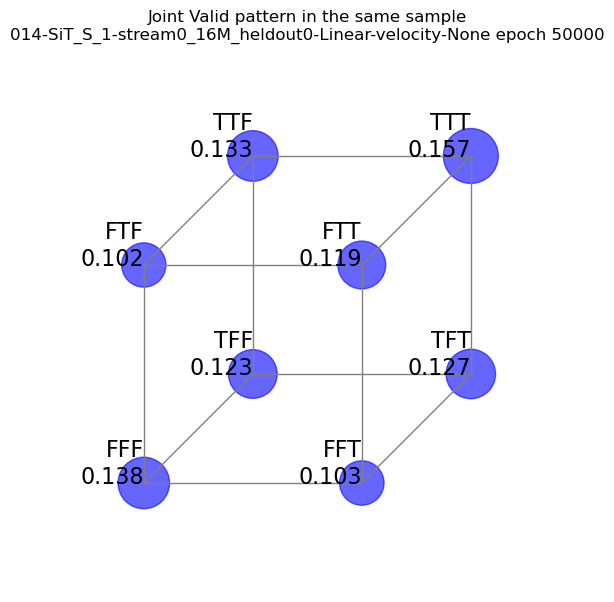

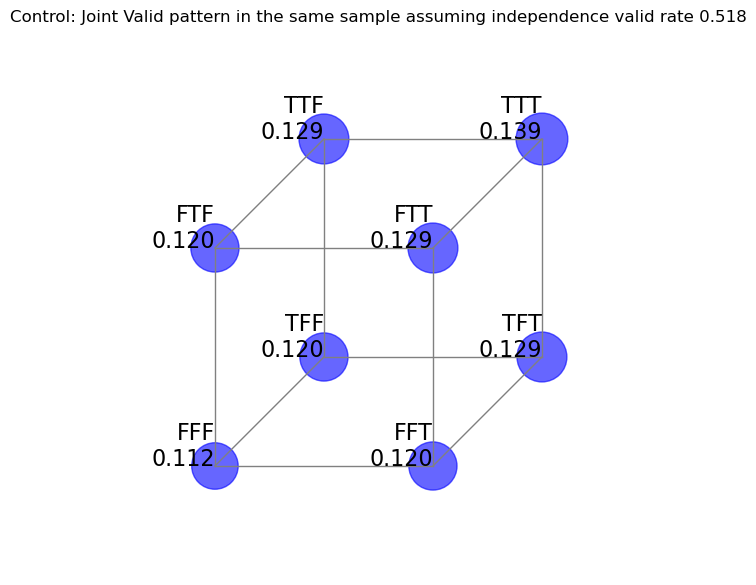

In [93]:
bin_pattern, counts = np.unique(validmat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Joint Valid pattern in the same sample\n{expname} epoch {epoch_id}")
saveallforms(figexpdir, f"sample_row_validity_joint_cube_epoch{epoch_id}", figh)
figh.show()
row_total = validmat.shape[0]
marginal_rate = validmat.astype(float).mean()
ctrl_cnts = np.zeros((8, ), dtype=int)
for i, pattern in enumerate(bin_pattern):
    ctrl_cnts[i] = marginal_rate ** sum(pattern) * (1 - marginal_rate) ** (3 - sum(pattern)) * row_total
figh = plot_binary_patterns_with_connections(ctrl_cnts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Control: Joint Valid pattern in the same sample assuming independence valid rate {marginal_rate:.3f}")
saveallforms(figexpdir, f"sample_row_validity_joint_independence_ctrl_epoch{epoch_id}", figh)
figh.show()

In [ ]:
rule_list_all_list

[[[], [30], []],
 [[21, 32], [32], [15]],
 [[], [3], []],
 [[3], [16], [10]],
 [[], [], []],
 [[], [], [36]],
 [[1, 32], [5], [22]],
 [[23], [30], [23]],
 [[26], [], []],
 [[20], [], [15]],
 [[], [6], [0]],
 [[], [], []],
 [[3], [6, 25], [23]],
 [[], [4], []],
 [[32], [], []],
 [[4], [4], []],
 [[20], [], [20]],
 [[], [], [5]],
 [[35], [15, 26], [13, 35]],
 [[26], [], []],
 [[], [6], [6]],
 [[26], [], [26]],
 [[], [], []],
 [[1, 26], [], [6]],
 [[], [], [15]],
 [[], [16], [36]],
 [[], [36], [36]],
 [[], [], [7]],
 [[6], [36], [2, 21, 31]],
 [[], [], [25]],
 [[36], [], []],
 [[], [0, 30], []],
 [[0], [5, 16, 32], [6, 23, 32]],
 [[26], [20], []],
 [[], [], [16]],
 [[31], [15, 20], [36]],
 [[2], [], [0, 15, 36]],
 [[], [14, 26], []],
 [[], [], [6]],
 [[], [], []],
 [[1], [22], [26, 30]],
 [[33], [21, 38], []],
 [[24], [36], []],
 [[23], [33], []],
 [[], [32], []],
 [[], [], [7]],
 [[15], [16, 26], [6, 36]],
 [[], [], [2]],
 [[13, 30], [5], []],
 [[32], [], []],
 [[], [1], []],
 [[3, 31], 

In [50]:
validmat

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False],
       ...,
       [ True, False,  True],
       [ True,  True,  True],
       [ True, False, False]])

#### Independence as a function of training time

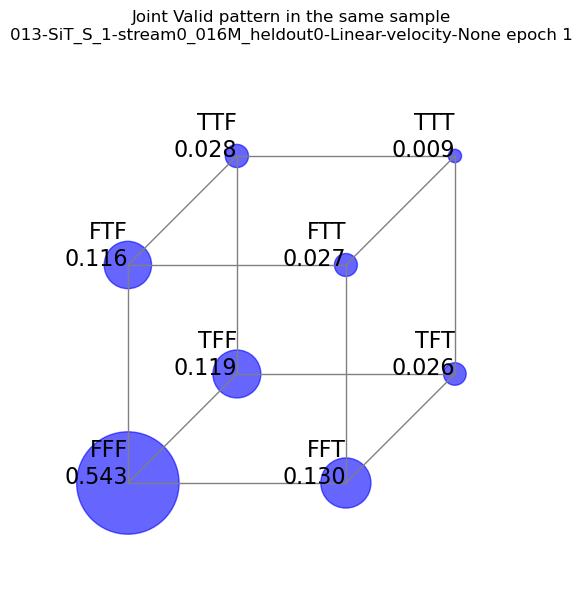

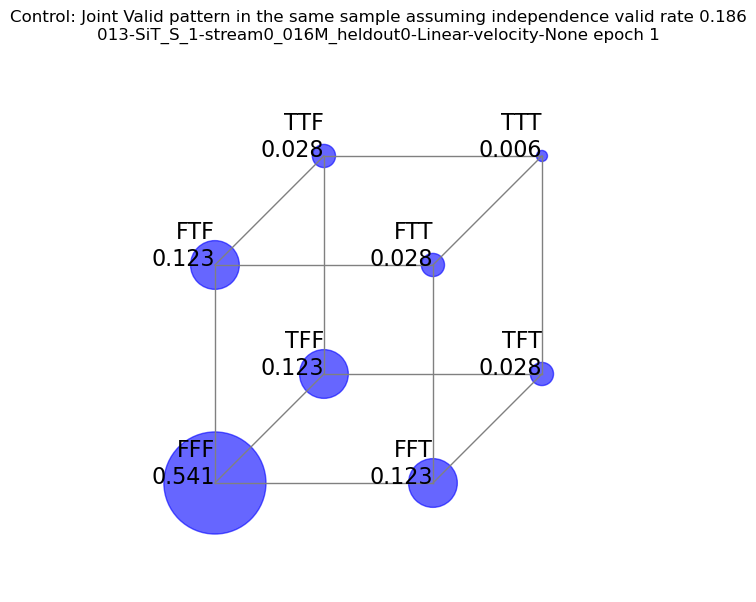

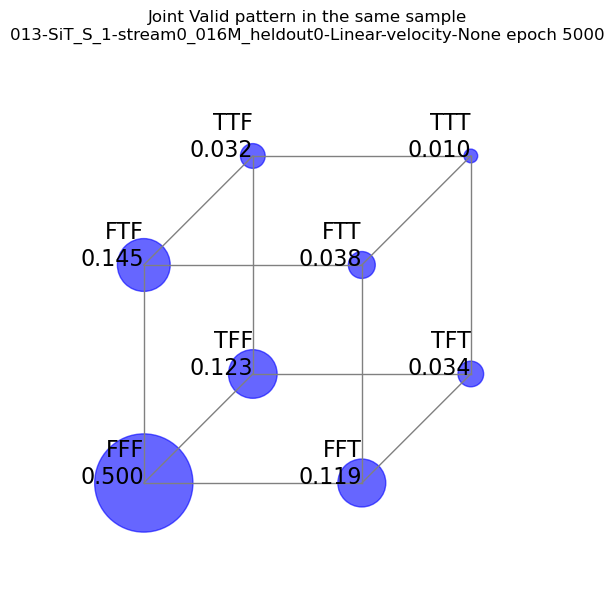

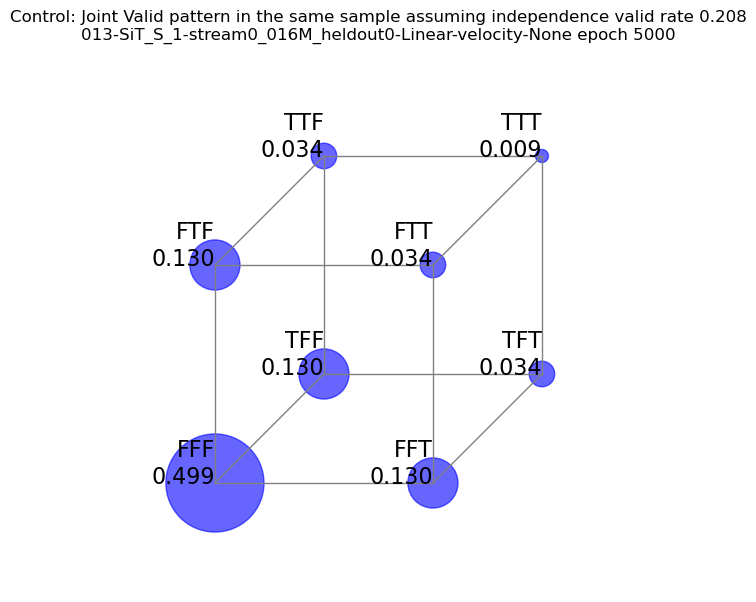

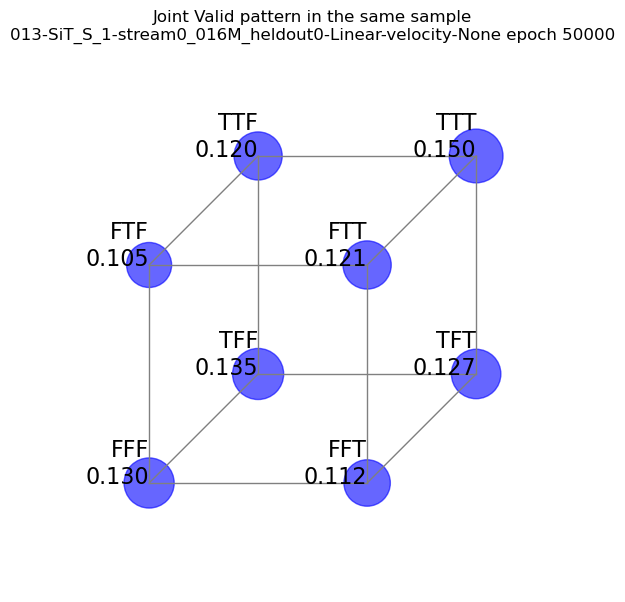

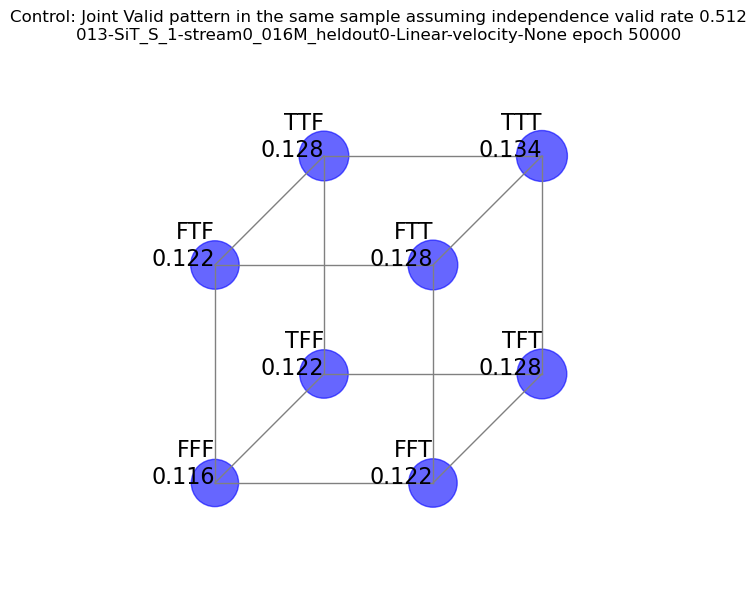

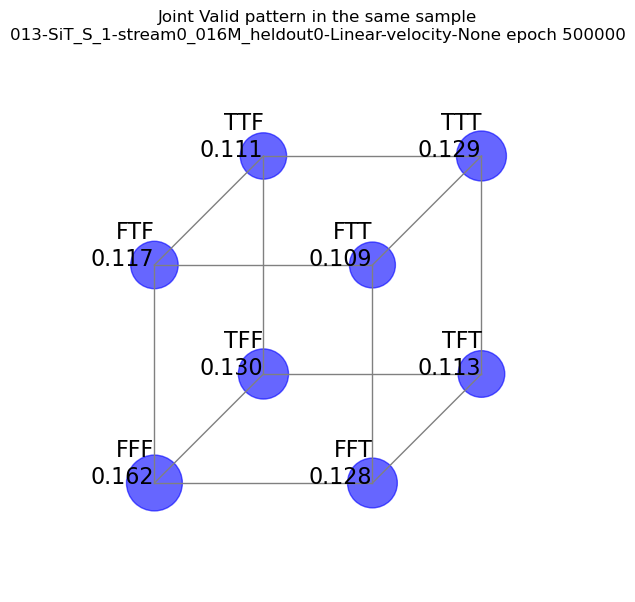

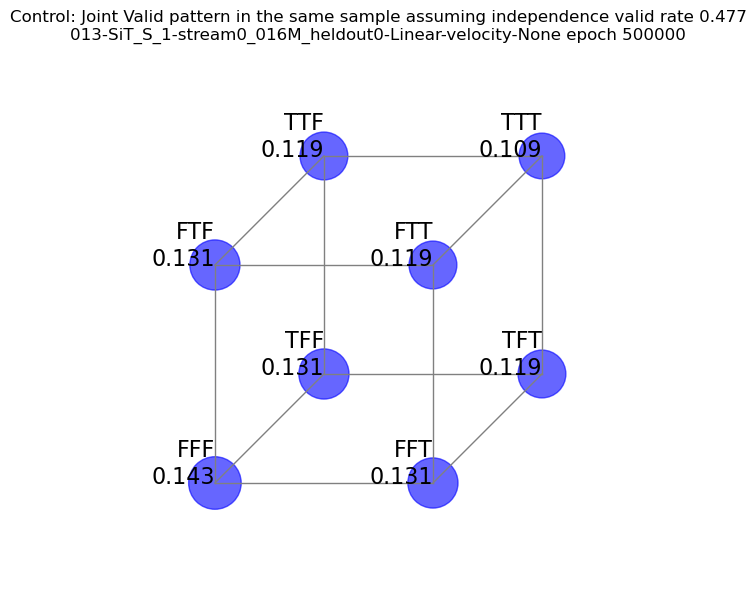

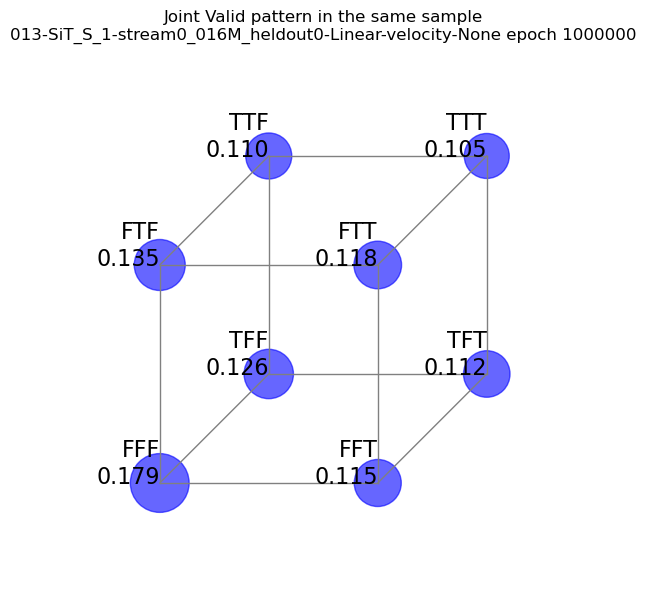

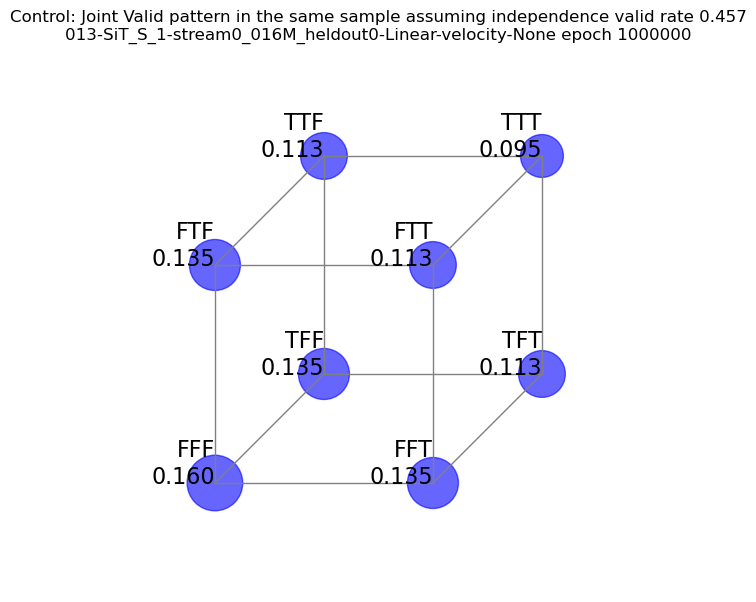

In [101]:
epoch_id = 500000 # 100000
for epoch_id in [1, 5000, 50000, 500000, 1000000]:
    rule_list_all = eval_col[epoch_id]['rule_col']
    rule_list_all_arr = np.array(rule_list_all, dtype=object)
    rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
    rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
    validmat = rulenummat > 0

    bin_pattern, counts = np.unique(validmat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
    figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq")
    figh.gca().set_title(f"Joint Valid pattern in the same sample\n{expname} epoch {epoch_id}")
    saveallforms(figexpdir, f"sample_row_validity_joint_cube_epoch{epoch_id}", figh)
    figh.show()
    row_total = validmat.shape[0]
    marginal_rate = validmat.astype(float).mean()
    ctrl_cnts = np.zeros((8, ), dtype=int)
    for i, pattern in enumerate(bin_pattern):
        ctrl_cnts[i] = marginal_rate ** sum(pattern) * (1 - marginal_rate) ** (3 - sum(pattern)) * row_total
    figh = plot_binary_patterns_with_connections(ctrl_cnts, binary_patterns=bin_pattern, text="freq")
    figh.gca().set_title(f"Control: Joint Valid pattern in the same sample assuming independence valid rate {marginal_rate:.3f}\n{expname} epoch {epoch_id}")
    saveallforms(figexpdir, f"sample_row_validity_joint_independence_ctrl_epoch{epoch_id}", figh)
    figh.show()

In [57]:
epoch_id = 500000 # 100000
rule_list_all = eval_col[epoch_id]['rule_col']
rule_list_all_arr = np.array(rule_list_all, dtype=object)
rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
validmat = rulenummat > 0

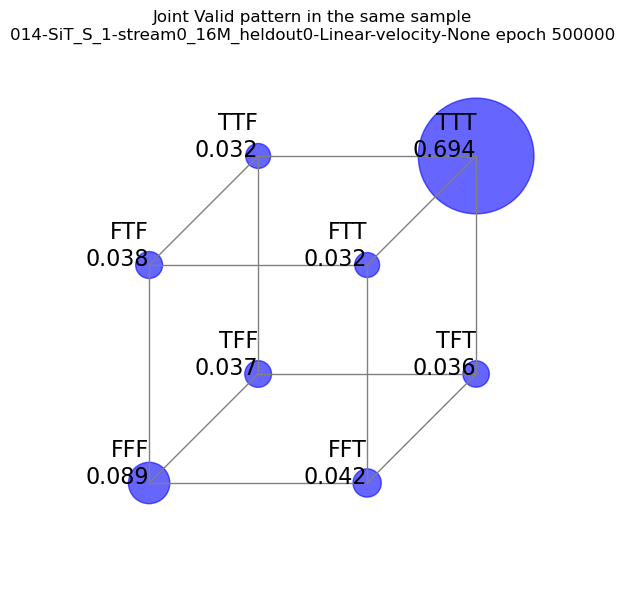

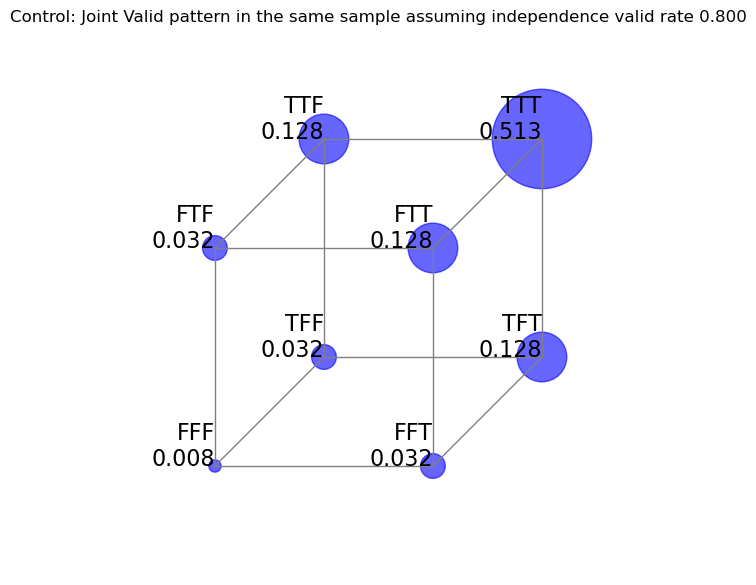

In [58]:
bin_pattern, counts = np.unique(validmat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Joint Valid pattern in the same sample\n{expname} epoch {epoch_id}")
# saveallforms(figexpdir, "memorization_row_joint_cnt_cube_final_epoch", figh)
figh.show()

row_total = validmat.shape[0]
marginal_rate = validmat.astype(float).mean()
ctrl_cnts = np.zeros((8, ), dtype=int)
for i, pattern in enumerate(bin_pattern):
    ctrl_cnts[i] = marginal_rate ** sum(pattern) * (1 - marginal_rate) ** (3 - sum(pattern)) * row_total
figh = plot_binary_patterns_with_connections(ctrl_cnts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Control: Joint Valid pattern in the same sample assuming independence valid rate {marginal_rate:.3f}")
# saveallforms(figexpdir, "control_memorization_row_joint_independence", figh)
figh.show()

In [59]:
epoch_id = 1000000 # 100000
rule_list_all = eval_col[epoch_id]['rule_col']
rule_list_all_arr = np.array(rule_list_all, dtype=object)
rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
validmat = rulenummat > 0

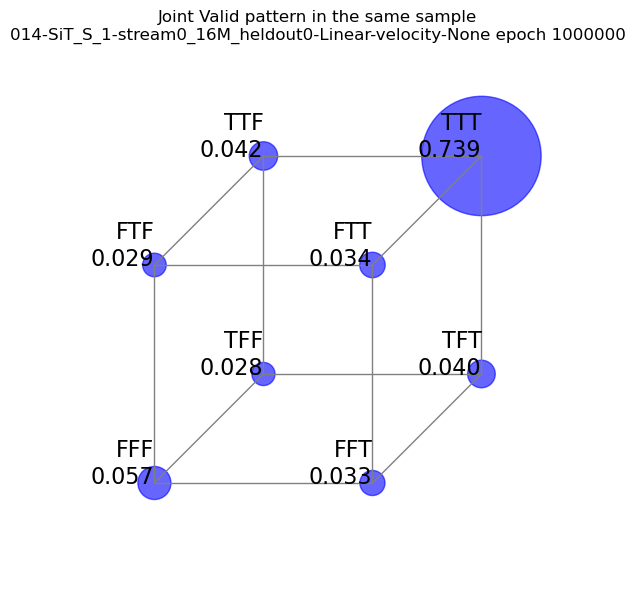

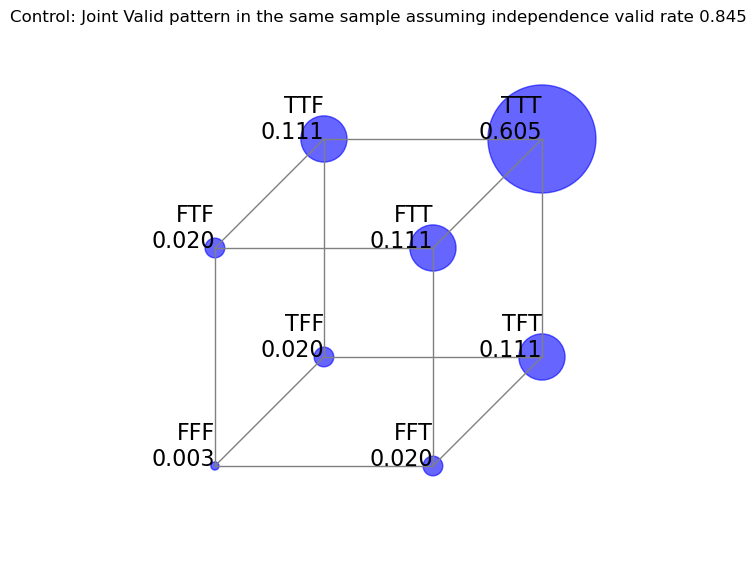

In [60]:
bin_pattern, counts = np.unique(validmat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Joint Valid pattern in the same sample\n{expname} epoch {epoch_id}")
# saveallforms(figexpdir, "memorization_row_joint_cnt_cube_final_epoch", figh)
figh.show()

row_total = validmat.shape[0]
marginal_rate = validmat.astype(float).mean()
ctrl_cnts = np.zeros((8, ), dtype=int)
for i, pattern in enumerate(bin_pattern):
    ctrl_cnts[i] = marginal_rate ** sum(pattern) * (1 - marginal_rate) ** (3 - sum(pattern)) * row_total
figh = plot_binary_patterns_with_connections(ctrl_cnts, binary_patterns=bin_pattern, text="freq")
figh.gca().set_title(f"Control: Joint Valid pattern in the same sample assuming independence valid rate {marginal_rate:.3f}")
# saveallforms(figexpdir, "control_memorization_row_joint_independence", figh)
figh.show()

### Control rate of C3 and C2

In [97]:
epoch_id = 50000 # 100000 # 500000
rule_list_all = eval_col[epoch_id]['rule_col']
rule_list_all_arr = np.array(rule_list_all, dtype=object)
rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
validmat = rulenummat > 0

In [98]:
rule_dist_vec = np.zeros((40, ), dtype=int)
rule_invalid_cnt = 0
for rule_set in rule_list_all_arr.flatten():
    for rule in rule_set:
        rule_dist_vec[rule] += 1
    if len(rule_set) == 0:
        rule_invalid_cnt += 1
row_total = len(rule_list_all_arr.flatten())
print(f"rule invalid rate {rule_invalid_cnt / row_total:.3f}")

rule invalid rate 0.482


In [88]:
rule_dist_vec

array([183,  39, 129, 100, 118, 330, 365,  13,   8,  39, 110,  28,  95,
        80,  55, 188, 195,  24,   4,  29, 101,  51,  87,  80,  55, 218,
       260,   5,   1,  13, 181, 105, 206, 138,  27,  97, 216,   5,  81,
        46])

In [90]:
rule_freq = rule_dist_vec / row_total
rule_freq

array([0.02978516, 0.00634766, 0.02099609, 0.01627604, 0.01920573,
       0.05371094, 0.05940755, 0.00211589, 0.00130208, 0.00634766,
       0.01790365, 0.00455729, 0.01546224, 0.01302083, 0.00895182,
       0.03059896, 0.03173828, 0.00390625, 0.00065104, 0.00472005,
       0.0164388 , 0.00830078, 0.01416016, 0.01302083, 0.00895182,
       0.03548177, 0.04231771, 0.0008138 , 0.00016276, 0.00211589,
       0.02945964, 0.01708984, 0.03352865, 0.02246094, 0.00439453,
       0.01578776, 0.03515625, 0.0008138 , 0.01318359, 0.00748698])

### Independence / contingency KL curve

In [38]:
import numpy as np
from scipy.stats import chi2_contingency

In [21]:
def build_contingency_table(data):
    """
    Builds a 3D contingency table for three binary variables using numpy.unique.
    
    :param data: NumPy array of shape (n_samples, 3) with boolean values.
    :return: 3D NumPy array of shape (2, 2, 2) with counts.
    """
    # Ensure the data is a NumPy array of integers (0 and 1)
    data_int = data.astype(int)
    # Compute unique rows and their counts
    unique_rows, counts = np.unique(data_int, axis=0, return_counts=True)
    # Initialize a 3D contingency table with zeros
    contingency_table = np.zeros((2, 2, 2), dtype=int)
    # Populate the contingency table
    for row, count in zip(unique_rows, counts):
        a, b, c = row
        contingency_table[a, b, c] = count
    
    return contingency_table

In [22]:
def calculate_cramers_v(chi2, n, min_dim):
    """
    Calculates Cramér's V statistic.
    
    :param chi2: Chi-square statistic from the test.
    :param n: Total number of observations.
    :param min_dim: Minimum dimension (min(k_i - 1) for each variable i).
    :return: Cramér's V value.
    """
    return np.sqrt(chi2 / (n * min_dim))

#### Function demo for one epoch

In [ ]:
epoch_id = 500000 # 100000
rule_list_all = eval_col[epoch_id]['rule_col']
rule_list_all_arr = np.array(rule_list_all, dtype=object)
# rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
validmat = rulenummat > 0
bin_pattern, counts = np.unique(validmat, axis=0, return_counts=True) # the joint distribution of memorization in the same row. 
# figh = plot_binary_patterns_with_connections(counts, binary_patterns=bin_pattern, text="freq")
# figh.gca().set_title(f"Joint Valid pattern in the same sample\n{expname} epoch {epoch_id}")
# # saveallforms(figexpdir, "memorization_row_joint_cnt_cube_final_epoch", figh)
# figh.show()
row_total = validmat.shape[0]
marginal_rate = validmat.astype(float).mean()
ctrl_cnts = np.zeros((8, ), dtype=int)
for i, pattern in enumerate(bin_pattern):
    ctrl_cnts[i] = marginal_rate ** sum(pattern) * (1 - marginal_rate) ** (3 - sum(pattern)) * row_total

In [ ]:
contingency_table = build_contingency_table(validmat)
print(contingency_table)
# Step 2: Perform Chi-Square Test of Independence
# chi2_contingency can handle multi-dimensional tables
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test Results:")
print(f"Chi-square Statistic: {chi2}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p}")
# Step 3: Calculate Cramér's V
n = contingency_table.sum()
# For three binary variables, min_dim = min(k_i - 1) = 1
min_dim = 1
cramers_v = calculate_cramers_v(chi2, n, min_dim)
print(f"Cramér's V: {cramers_v:.4f}")
# Step 4: Interpretation
alpha = 0.05
if p < alpha:
    print("\nResult: The variables are not independent (reject H₀ at α=0.05).")
else:
    print("\nResult: The variables are independent (fail to reject H₀ at α=0.05).")

print(f"Association Strength (Cramér's V): {cramers_v:.4f}")

[[[367 235]
  [276 241]]

 [[259 230]
  [225 215]]]

Chi-Square Test Results:
Chi-square Statistic: 13.04714149829311
Degrees of Freedom: 4
P-value: 0.01104773454908829
Cramér's V: 0.0798

Result: The variables are not independent (reject H₀ at α=0.05).
Association Strength (Cramér's V): 0.0798


#### Lower data regime

In [ ]:
# for expfullname in ["014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs",]:
#                     # "017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
expfullname = "013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs"
# expfullname = "014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
tb_record = tb_data_col_SiT[expfullname]
expname = expfullname.split("/tensorboard_logs")[0]
prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, SiT_exproot, prefix=prefix)
sample_col = sweep_collect_sample(expname, SiT_exproot, non_prefix=prefix)
print("step min %d max %d, total %d saves" % (min(sample_col.keys()), max(sample_col.keys()), len(sample_col.keys())))

figexpdir = join(figdir, expfullname.split("/")[0])
os.makedirs(figexpdir, exist_ok=True)

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/samples
example file: 0155000.pt


  0%|          | 0/402 [00:00<?, ?it/s]

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/samples
example file: ['0155000.pt', '0422500.pt', '0432500.pt', '0715000.pt', '0787500.pt', '0072500.pt', '0277500.pt', 'sample_rule_eval_465000.pt', 'sample_rule_eval_602500.pt', '0707500.pt']


  0%|          | 0/402 [00:00<?, ?it/s]

step min 0 max 1000000, total 402 saves


In [23]:
epoch_id = 500000 # 100000
valid_stats_col = {}
for epoch_id in tqdm(eval_col.keys()):
    #tqdm([1, *range(5000, 500000, 5000), *range(500000, 1000001, 50000)]):
    rule_list_all = eval_col[epoch_id]['rule_col']
    rule_list_all_arr = np.array(rule_list_all, dtype=object)
    # rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
    rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
    validmat = rulenummat > 0
    # row_total = validmat.shape[0]
    # marginal_rate = validmat.astype(float).mean()
    # ctrl_cnts = np.zeros((8, ), dtype=int)
    # for i, pattern in enumerate(bin_pattern):
    #     ctrl_cnts[i] = marginal_rate ** sum(pattern) * (1 - marginal_rate) ** (3 - sum(pattern)) * row_total
    contingency_table = build_contingency_table(validmat)
    # print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # print("\nChi-Square Test Results:")
    # print(f"Chi-square Statistic: {chi2}")
    # print(f"Degrees of Freedom: {dof}")
    # print(f"P-value: {p}")
    # Step 3: Calculate Cramér's V
    n = contingency_table.sum()
    # For three binary variables, min_dim = min(k_i - 1) = 1
    min_dim = 1
    cramers_v = calculate_cramers_v(chi2, n, min_dim)
    stats = {"chi2": chi2, "p": p, "dof": dof, "cramers_v": cramers_v , "contingency_table": contingency_table, "expected": expected, "marginal_rate": validmat.astype(float).mean()}
    valid_stats_col[epoch_id] = stats

valid_stats_df = pd.DataFrame(valid_stats_col).T

  0%|          | 0/402 [00:00<?, ?it/s]

In [34]:
valid_stats_df.to_csv(join(figexpdir, "valid_stats_df.csv"))
valid_stats_df.to_pickle(join(figexpdir, "valid_stats_df.pkl"))

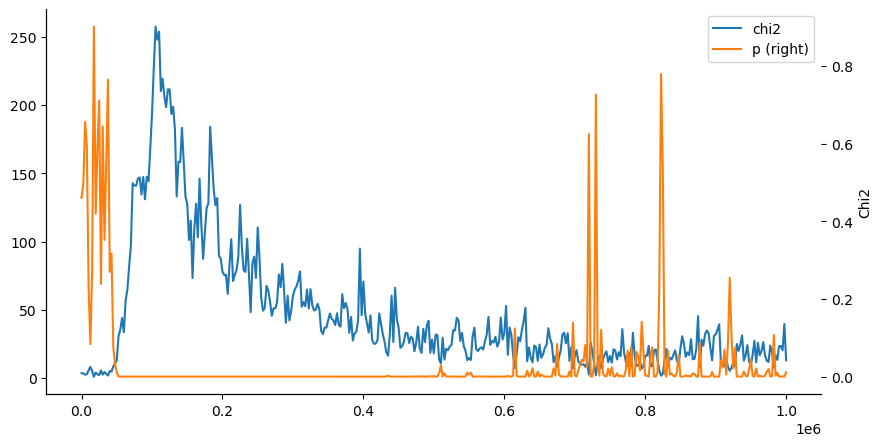

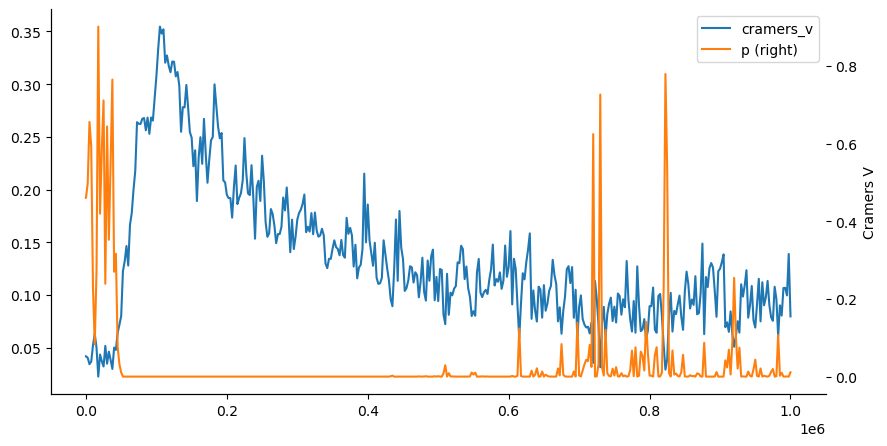

In [33]:
# make the 
valid_stats_df.plot(y=["chi2", "p", ], secondary_y=["p"], figsize=(10, 5))
plt.ylabel("Chi2")
plt.show()
valid_stats_df.plot(y=["cramers_v", "p", ], secondary_y=["p"], figsize=(10, 5))
plt.ylabel("Cramers V")
plt.show()

#### Higher data regime

In [35]:
# expfullname = "013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs"
expfullname = "014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
tb_record = tb_data_col_SiT[expfullname]
expname = expfullname.split("/tensorboard_logs")[0]
prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, SiT_exproot, prefix=prefix)
sample_col = sweep_collect_sample(expname, SiT_exproot, non_prefix=prefix)
print("step min %d max %d, total %d saves" % (min(sample_col.keys()), max(sample_col.keys()), len(sample_col.keys())))

figexpdir = join(figdir, expfullname.split("/")[0])
os.makedirs(figexpdir, exist_ok=True)

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/samples
example file: 0155000.pt


  0%|          | 0/402 [00:00<?, ?it/s]

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/samples
example file: ['0155000.pt', '0422500.pt', '0432500.pt', '0715000.pt', '0787500.pt', '0072500.pt', '0277500.pt', 'sample_rule_eval_465000.pt', 'sample_rule_eval_602500.pt', '0707500.pt']


  0%|          | 0/402 [00:00<?, ?it/s]

step min 0 max 1000000, total 402 saves


In [36]:
valid_stats_col = {}
for epoch_id in tqdm(eval_col.keys()):
    #tqdm([1, *range(5000, 500000, 5000), *range(500000, 1000001, 50000)]):
    rule_list_all = eval_col[epoch_id]['rule_col']
    rule_list_all_arr = np.array(rule_list_all, dtype=object)
    # rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
    rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
    validmat = rulenummat > 0
    contingency_table = build_contingency_table(validmat)
    # print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # print("\nChi-Square Test Results:")
    # print(f"Chi-square Statistic: {chi2}")
    # print(f"Degrees of Freedom: {dof}")
    # print(f"P-value: {p}")
    # Step 3: Calculate Cramér's V
    n = contingency_table.sum()
    # For three binary variables, min_dim = min(k_i - 1) = 1
    min_dim = 1
    cramers_v = calculate_cramers_v(chi2, n, min_dim)
    stats = {"chi2": chi2, "p": p, "dof": dof, "cramers_v": cramers_v , "contingency_table": contingency_table, "expected": expected, "marginal_rate": validmat.astype(float).mean()}
    valid_stats_col[epoch_id] = stats

valid_stats_df = pd.DataFrame(valid_stats_col).T
valid_stats_df.to_csv(join(figexpdir, "valid_stats_df.csv"))
valid_stats_df.to_pickle(join(figexpdir, "valid_stats_df.pkl"))

  0%|          | 0/402 [00:00<?, ?it/s]

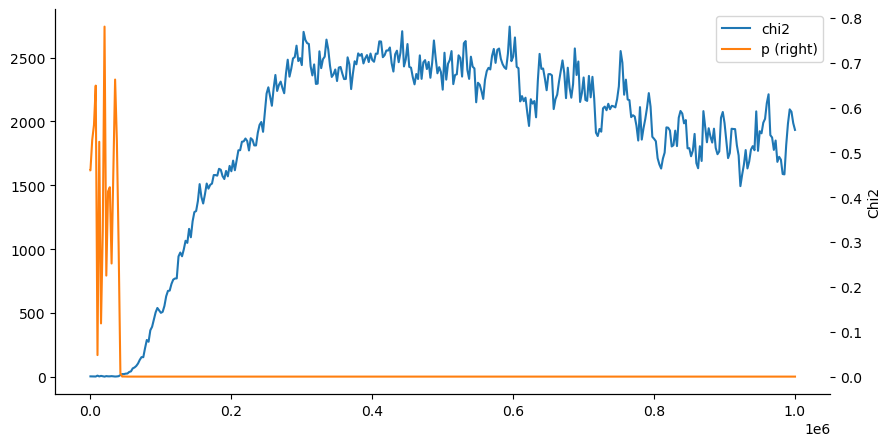

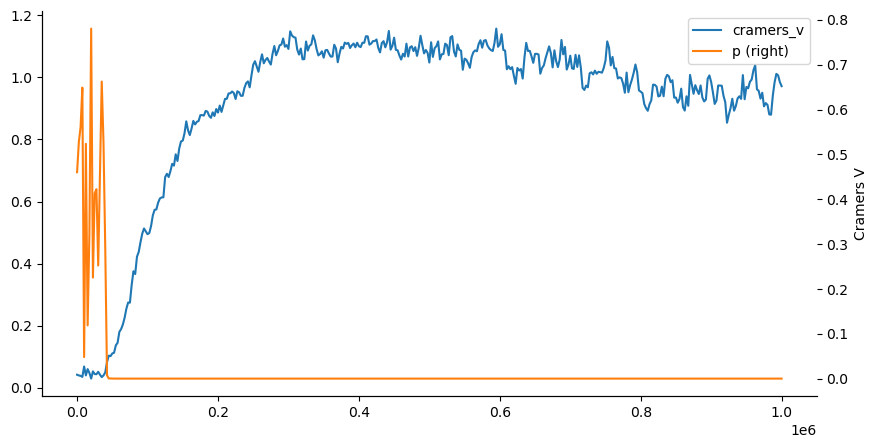

In [37]:
# make the 
valid_stats_df.plot(y=["chi2", "p", ], secondary_y=["p"], figsize=(10, 5))
plt.ylabel("Chi2")
plt.show()
valid_stats_df.plot(y=["cramers_v", "p", ], secondary_y=["p"], figsize=(10, 5))
plt.ylabel("Cramers V")
plt.show()

#### Rule identity independence test

In [39]:
# for expfullname in ["014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs",]:
#                     # "017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
expfullname = "013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs"
# expfullname = "014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs"
tb_record = tb_data_col_SiT[expfullname]
expname = expfullname.split("/tensorboard_logs")[0]
prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, SiT_exproot, prefix=prefix)
sample_col = sweep_collect_sample(expname, SiT_exproot, non_prefix=prefix)
print("step min %d max %d, total %d saves" % (min(sample_col.keys()), max(sample_col.keys()), len(sample_col.keys())))

figexpdir = join(figdir, expfullname.split("/")[0])
os.makedirs(figexpdir, exist_ok=True)

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/samples
example file: 0155000.pt


  0%|          | 0/402 [00:00<?, ?it/s]

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results/013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/samples
example file: ['0155000.pt', '0422500.pt', '0432500.pt', '0715000.pt', '0787500.pt', '0072500.pt', '0277500.pt', 'sample_rule_eval_465000.pt', 'sample_rule_eval_602500.pt', '0707500.pt']


  0%|          | 0/402 [00:00<?, ?it/s]

step min 0 max 1000000, total 402 saves


In [ ]:
rule_list_all_arr

In [44]:
rule_list_all_arr[:5,:]

array([[array([15, 21]), array([], dtype=float64), array([11])],
       [array([], dtype=float64), array([12]), array([16])],
       [array([29]), array([], dtype=float64), array([], dtype=float64)],
       [array([], dtype=float64), array([5]), array([11])],
       [array([], dtype=float64), array([], dtype=float64),
        array([], dtype=float64)]], dtype=object)

In [48]:
def convert_to_binary_array(data):
    """
    Converts an (N, 3) array of lists or None to a binary (N, 3, 40) array.

    Parameters:
    - data: numpy.ndarray of shape (N, 3), where each element is either None or a list of ints from 0-39.

    Returns:
    - binary_array: numpy.ndarray of shape (N, 3, 40), dtype=int8
    """
    N, M = data.shape  # M should be 3
    binary_array = np.zeros((N, M, 40), dtype=bool)
    # Iterate over the first two dimensions
    for i in range(N):
        for j in range(M):
            lst = data[i, j]
            if lst is not None and len(lst) > 0:
                binary_array[i, j, lst] = True

    return binary_array

In [49]:
epoch_id = 50000
rule_list_all = eval_col[epoch_id]['rule_col']
rule_list_all_arr = np.array(rule_list_all, dtype=object)
rule_all_tsr = convert_to_binary_array(rule_list_all_arr)
# rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
assert np.allclose(rule_all_tsr.sum(axis=(-1)), rulenummat)

In [67]:
rule_id = 38
contingency_table = build_contingency_table(rule_all_tsr[:,:,rule_id])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test Results:")
print(f"Chi-square Statistic: {chi2}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p}")


Chi-Square Test Results:
Chi-square Statistic: 2347.0910672684004
Degrees of Freedom: 4
P-value: 0.0


In [77]:
epoch_id = 500000
rule_list_all = eval_col[epoch_id]['rule_col']
rule_list_all_arr = np.array(rule_list_all, dtype=object)
rule_all_tsr = convert_to_binary_array(rule_list_all_arr)
# rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
assert np.allclose(rule_all_tsr.sum(axis=(-1)), rulenummat)
rule_chi2_col = {}
for rule_id in range(40):
    contingency_table = build_contingency_table(rule_all_tsr[:,:,rule_id])
    try:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        n = contingency_table.sum()
        # For three binary variables, min_dim = min(k_i - 1) = 1
        min_dim = 1
        cramers_v = calculate_cramers_v(chi2, n, min_dim)
    except ValueError as e:
        chi2, p, dof, expected = np.nan, np.nan, np.nan, None
        cramers_v = np.nan
    rule_chi2_col[rule_id] = {"chi2": chi2, "p": p, "dof": dof, "cramers_v": cramers_v , "contingency_table": contingency_table, "expected": expected}

rule_chi2_df = pd.DataFrame(rule_chi2_col).T

<Axes: >

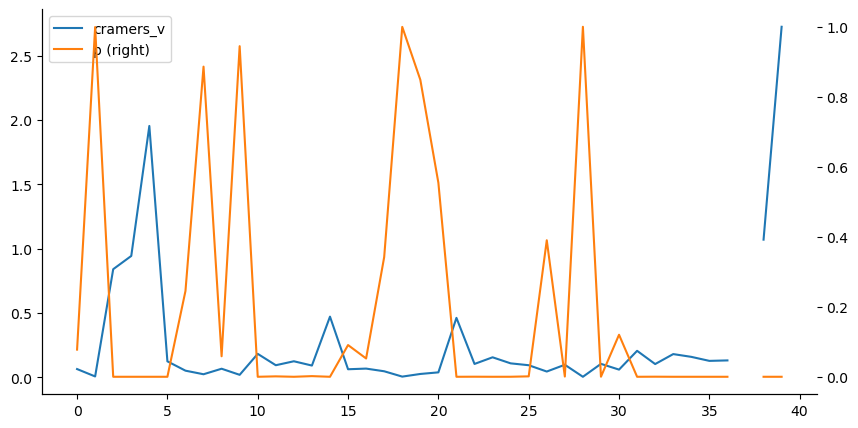

In [80]:
rule_chi2_df.plot(y=["cramers_v", "p", ], secondary_y=["p"], figsize=(10, 5))

In [78]:
# filter index where p < 0.01
rule_chi2_df.index[rule_chi2_df["p"] > 0.01]

Index([0, 1, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 26, 28, 30], dtype='int64')

In [81]:
contingency_table

array([[[1997,    4],
        [  12,    4]],

       [[   4,    8],
        [   9,   10]]])

In [84]:
rule_all_tsr[:,:,rule_id].mean()

0.014973958333333334

In [88]:
epoch_id = 500000 # 100000
rule_stats_col = {}
for epoch_id in tqdm(eval_col.keys()):
    # tqdm([1, *range(5000, 500000, 5000), *range(500000, 1000001, 50000)]):
    rule_list_all = eval_col[epoch_id]['rule_col']
    rule_list_all_arr = np.array(rule_list_all, dtype=object)
    rule_all_tsr = convert_to_binary_array(rule_list_all_arr)
    # rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
    # rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
    # assert np.allclose(rule_all_tsr.sum(axis=(-1)), rulenummat)
    for rule_id in range(40):
        contingency_table = build_contingency_table(rule_all_tsr[:,:,rule_id])
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            n = contingency_table.sum()
            # For three binary variables, min_dim = min(k_i - 1) = 1
            min_dim = 1
            cramers_v = calculate_cramers_v(chi2, n, min_dim)
        except ValueError as e:
            chi2, p, dof, expected = np.nan, np.nan, np.nan, None
            cramers_v = np.nan
        rule_stats_col[(epoch_id, rule_id)] = {"chi2": chi2, "p": p, "dof": dof, "cramers_v": cramers_v , "contingency_table": contingency_table, "expected": expected, "marginal_rate": rule_all_tsr[:,:,rule_id].mean()}

rule_stats_df = pd.DataFrame(rule_stats_col).T

  0%|          | 0/402 [00:00<?, ?it/s]

In [89]:
rule_stats_df

chi2         p  dof cramers_v  \
0       0           NaN       NaN  NaN       NaN   
        1           NaN       NaN  NaN       NaN   
        2           NaN       NaN  NaN       NaN   
        3           NaN       NaN  NaN       NaN   
        4           NaN       NaN  NaN       NaN   
...                 ...       ...  ...       ...   
1000000 35   128.403274       0.0    4  0.250394   
        36    23.959977  0.000081    4  0.108163   
        37          NaN       NaN  NaN       NaN   
        38   269.321266       0.0    4  0.362636   
        39  3012.384241       0.0    4  1.212803   

                                     contingency_table  \
0       0      [[[2048, 0], [0, 0]], [[0, 0], [0, 0]]]   
        1      [[[2048, 0], [0, 0]], [[0, 0], [0, 0]]]   
        2      [[[2048, 0], [0, 0]], [[0, 0], [0, 0]]]   
        3      [[[2048, 0], [0, 0]], [[0, 0], [0, 0]]]   
        4      [[[2048, 0], [0, 0]], [[0, 0], [0, 0]]]   
...                                                ...   
1000000 35  [[[1951, 34], [20, 2]], [[33, 5], [2, 1]]]   
        36  [[[1846, 50], [64, 9]], [[73, 4], [2, 0]]]   
        37     [[[2044, 2], [2, 0]], [[0, 0], [0, 0]]]   
        38  [[[1970, 17], [22, 5]], [[24, 6], [3, 1]]]   
        39   [[[2007, 10], [8, 2]], [[11, 2], [6, 2]]]   

                                                                                                       expected  \
0       0                                                                                                  None   
        1                                                                                                  None   
        2                                                                                                  None   
        3                                                                                                  None   
        4                                                                                                  None   
...                                                                                                         ...   
1000000 35  [[[1941.8437399864197, 40.65674829483032], [23.997080326080322, 0.5024313926696777]], [[39.66895...   
        36  [[[1838.5413753986359, 58.351691007614136], [69.88880038261414, 2.2181332111358643]], [[73.76575...   
        37                                                                                                 None   
        38  [[[1955.4277710914612, 28.08687734603882], [30.05367422103882, 0.43167734146118164]], [[33.01119...   
        39  [[[1993.4878158569336, 15.696754455566406], [17.676246643066406, 0.13918304443359375]], [[20.652...   

           marginal_rate  
0       0            0.0  
        1            0.0  
        2            0.0  
        3            0.0  
        4            0.0  
...                  ...  
1000000 35      0.017578  
        36      0.035319  
        37      0.000651  
        38      0.015299  
        39      0.008952  

[16080 rows x 7 columns]

<Axes: >

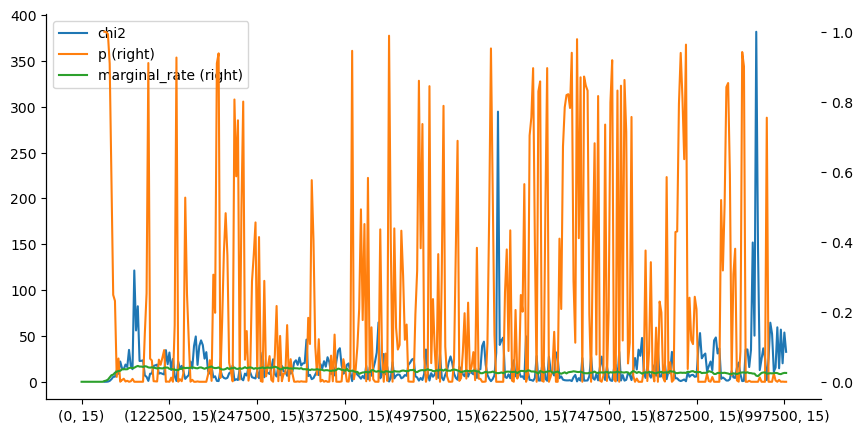

In [107]:
rule_stats_df.loc[pd.IndexSlice[:, 15], :].plot(y=["chi2", "p", "marginal_rate"], secondary_y=["p","marginal_rate"], figsize=(10, 5))

#### Concatenated samples for robustnes

In [135]:
rule_stats_cat_col = {}
epoch_list = sorted(list(eval_col.keys()))
cmb_step = 5
for ei in tqdm(range(0, len(epoch_list), cmb_step)):
    epoch_id = epoch_list[ei]
    combine_epoch_list = epoch_list[ei:ei+cmb_step]
    rule_list_cat = []
    for eid in combine_epoch_list:
        rule_list_all = eval_col[eid]['rule_col']
        rule_list_cat.extend(rule_list_all)
    rule_list_all_arr = np.array(rule_list_cat, dtype=object)
    rule_all_tsr = convert_to_binary_array(rule_list_all_arr)
    # rule_list_all_list = [[list(rule_set) for rule_set in row] for row in rule_list_all]
    # rulenummat = np.array([len(rule_set) for rule_set in rule_list_all_arr.flatten()]).reshape(rule_list_all_arr.shape)
    # assert np.allclose(rule_all_tsr.sum(axis=(-1)), rulenummat)
    for rule_id in range(40):
        contingency_table = build_contingency_table(rule_all_tsr[:,:,rule_id])
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            n = contingency_table.sum()
            # For three binary variables, min_dim = min(k_i - 1) = 1
            min_dim = 1
            cramers_v = calculate_cramers_v(chi2, n, min_dim)
        except ValueError as e:
            chi2, p, dof, expected = np.nan, np.nan, np.nan, None
            cramers_v = np.nan
        rule_stats_cat_col[(epoch_id, rule_id)] = {"chi2": chi2, "p": p, "dof": dof, "cramers_v": cramers_v , "contingency_table": contingency_table, "expected": expected, "marginal_rate": rule_all_tsr[:,:,rule_id].mean()}

rule_stats_cat_df = pd.DataFrame(rule_stats_cat_col).T

  0%|          | 0/81 [00:00<?, ?it/s]

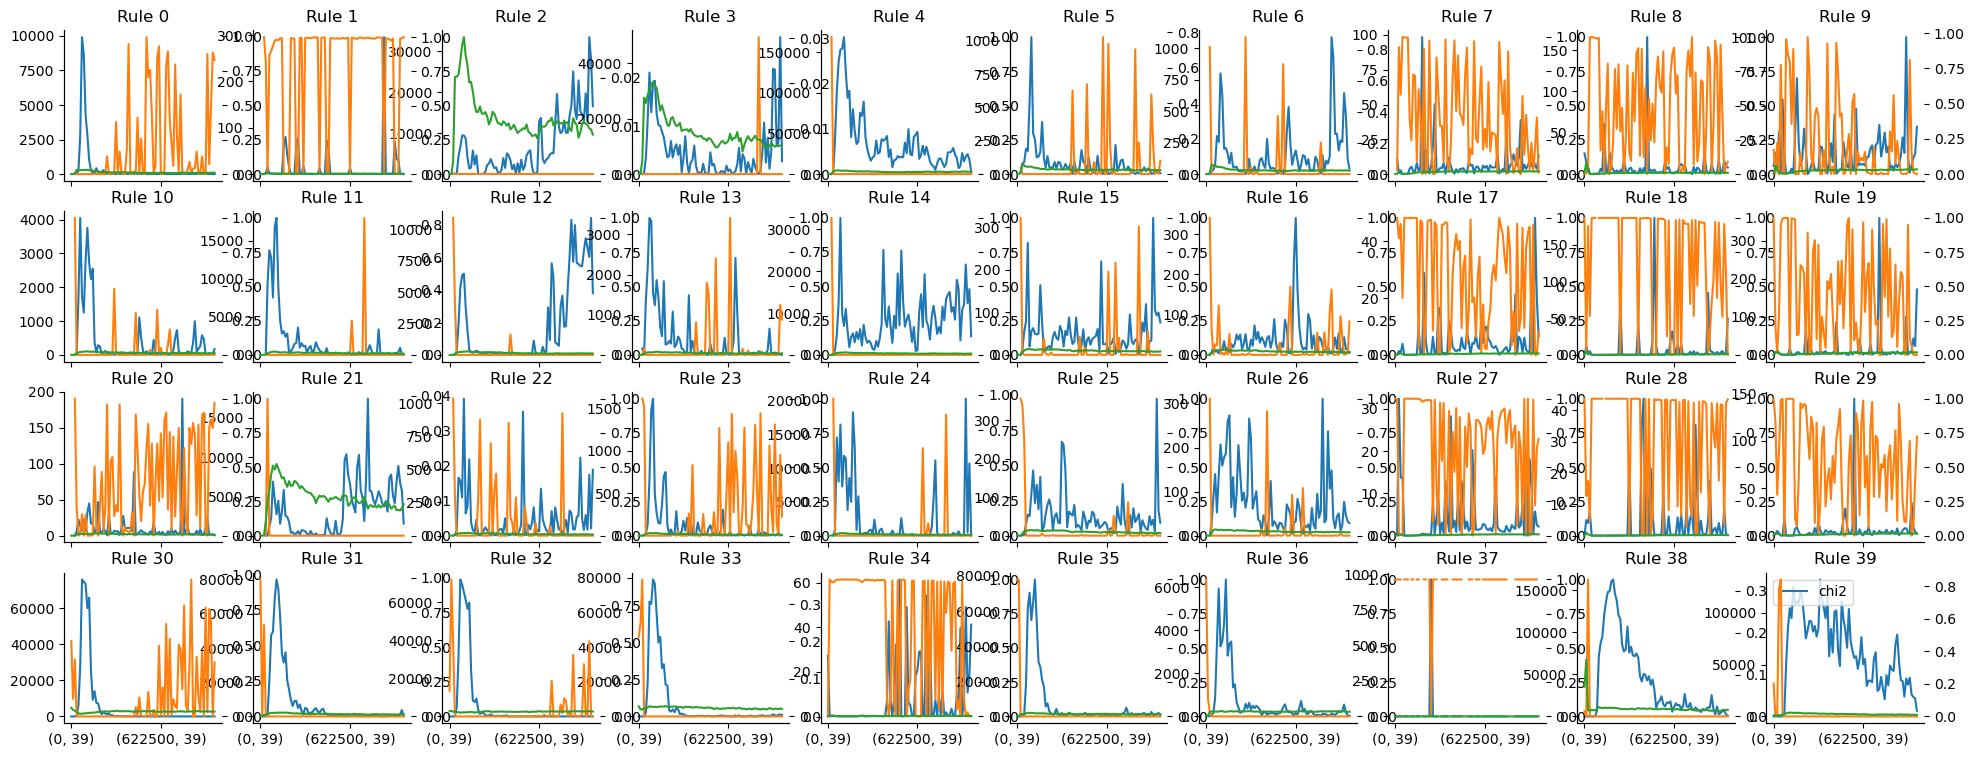

In [138]:
figh, axs = plt.subplots(4, 10, figsize=(24, 9), sharey=False, sharex=True)
axs = axs.flatten()
for rule_id in range(40):
    rule_stats_cat_df.loc[pd.IndexSlice[:, rule_id], :].plot(
        y=["chi2", "p", "marginal_rate"], secondary_y=["p","marginal_rate"], 
        ax=axs[rule_id], title=f"Rule {rule_id}")
    if rule_id == 39:
        axs[rule_id].legend(loc='upper left')
    else:
        axs[rule_id].get_legend().remove()
figh.show()

<Axes: >

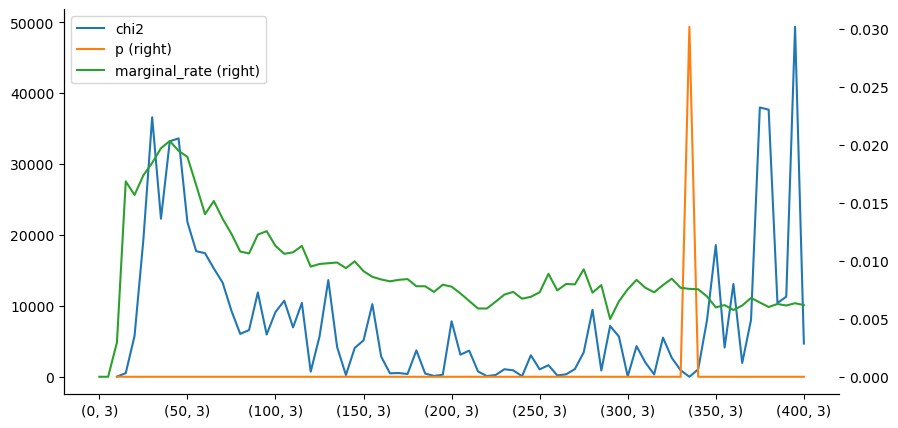

In [133]:
rule_stats_cat_df.loc[pd.IndexSlice[:, 3], :].plot(y=["chi2", "p", "marginal_rate"], secondary_y=["p","marginal_rate"], figsize=(10, 5))

In [84]:
rule_freq.sum()

0.6681315104166667

In [85]:
(rule_freq ** 3).sum()

0.0007464584885854965

In [96]:
(rule_freq ** 2).sum()

0.019642167621188693

In [37]:
rule_list_all[0][0]

[array([], dtype=float64), array([30]), array([], dtype=float64)]

In [36]:
rule_list_all_list

[[[array([], dtype=float64), array([30]), array([], dtype=float64)],
  [array([21, 32]), array([32]), array([15])],
  [array([], dtype=float64), array([3]), array([], dtype=float64)],
  [array([3]), array([16]), array([10])],
  [array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)],
  [array([], dtype=float64), array([], dtype=float64), array([36])],
  [array([ 1, 32]), array([5]), array([22])],
  [array([23]), array([30]), array([23])],
  [array([26]), array([], dtype=float64), array([], dtype=float64)],
  [array([20]), array([], dtype=float64), array([15])],
  [array([], dtype=float64), array([6]), array([0])],
  [array([], dtype=float64),
   array([], dtype=float64),
   array([], dtype=float64)],
  [array([3]), array([ 6, 25]), array([23])],
  [array([], dtype=float64), array([4]), array([], dtype=float64)],
  [array([32]), array([], dtype=float64), array([], dtype=float64)],
  [array([4]), array([4]), array([], dtype=float64)],
  [array([20]), array([]

In [26]:
eval_col[50000]['rule_col']

[[array([], dtype=float64), array([30]), array([], dtype=float64)],
 [array([21, 32]), array([32]), array([15])],
 [array([], dtype=float64), array([3]), array([], dtype=float64)],
 [array([3]), array([16]), array([10])],
 [array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64)],
 [array([], dtype=float64), array([], dtype=float64), array([36])],
 [array([ 1, 32]), array([5]), array([22])],
 [array([23]), array([30]), array([23])],
 [array([26]), array([], dtype=float64), array([], dtype=float64)],
 [array([20]), array([], dtype=float64), array([15])],
 [array([], dtype=float64), array([6]), array([0])],
 [array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64)],
 [array([3]), array([ 6, 25]), array([23])],
 [array([], dtype=float64), array([4]), array([], dtype=float64)],
 [array([32]), array([], dtype=float64), array([], dtype=float64)],
 [array([4]), array([4]), array([], dtype=float64)],
 [array([20]), array([], dtype=float64), arr